# Time Series Prediction With EchoTorch

## Import All Dependencies

In [2]:
# !pip install EchoTorch
# !pip install mdp
# !pip install scipy
# !pip install sklearn

In [2]:
import torch
import torch.optim as optim
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn as etnn
import echotorch.utils
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import mdp
import matplotlib.pyplot as plt

## Set Hyper Parameters

In [6]:
# Dataset params
train_sample_length = 5000
test_sample_length = 1000
n_train_samples = 1
n_test_samples = 1
batch_size = 1
spectral_radius = 0.9
leaky_rate = 1.0
input_dim = 1
n_hidden = 100

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

### Set Seed and GPU Usage

In [5]:
# Manual seed
mdp.numx.random.seed(1)
np.random.seed(2)
torch.manual_seed(1)

### Load the Dataset

In [7]:
# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10, seed=1)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10, seed=10)

# Data loader
trainloader = DataLoader(narma10_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(narma10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Define the Hidden Network

In [9]:
# ESN cell
esn = etnn.LiESN(input_dim=input_dim, hidden_dim=n_hidden, output_dim=1, spectral_radius=spectral_radius, learning_algo='inv', leaky_rate=leaky_rate)
if use_cuda:
    esn.cuda()

In [11]:
# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # To variable
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # Accumulate xTx and xTy
    esn(inputs, targets)

esn.finalize()

## Get MSE

In [12]:
# Train MSE
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()
y_predicted = esn(train_u)
print(u"Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data)))
print(u"")

Train MSE: 0.004655277822166681
Test NRMSE: 0.6365268862860002



In [13]:
# Test MSE
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()
y_predicted = esn(test_u)
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data)))
print(u"")

Test MSE: 0.005629844963550568
Test NRMSE: 0.683688674875532



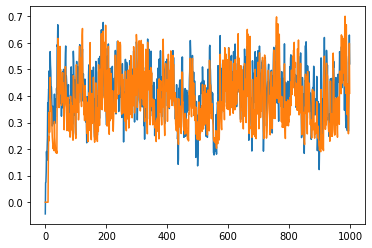

In [14]:
flattened_predictions = y_predicted.flatten()
flattened_true = test_y.flatten()
plt.plot(flattened_predictions)
plt.plot(flattened_true)
plt.show()